In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from itertools import product
from collections import Counter
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/results/resultados_svm.csv
/kaggle/input/datasetmodified/dataset-modificado.csv
/kaggle/working/__notebook_source__.ipynb


## Visualización inicial de los datos
Hacemos una visualización inicial de los datos, observando que todos los datos están transfromados a datos numéricos. También eliminamos una columna que se nos creó cuando transformamos el dataset.

In [2]:
data=pd.read_csv("/kaggle/input/datasetmodified/dataset-modificado.csv")
df=data.copy()
df=df.drop(["Unnamed: 0"],axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,8,17,1,1,5,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,8,22,0,1,5,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,9,19,1,1,3,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,8,21,0,0,4,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,8,14,0,1,5,8.0,0,0,0


## Dividimos el dataset
Tomamos la mitad de los datos para hacer validación cruzada

In [3]:
df = df.sample(frac=0.5)
df.shape

(159898, 17)

## Separamos los datos
Separamos los datos de nuestro dataset, ponemos las características que vamos a utilizar para entrenar en la variable X y la variable a predecir en la varibale Y.

In [5]:
X=df.iloc[:,1:17]
Y=df.iloc[:,0]

## Estandarización de los datos
Usamos StandardScaler para estandarizar las caracteríticas que vamos a usar para entrenar en nuestro modelo.

In [7]:
scaler=StandardScaler()
columns=X.columns
s=scaler.fit_transform(X)

scaled_data=pd.DataFrame(s,columns=columns)
scaled_data.head(5)

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0.406502,-0.838883,-0.270406,-0.197724,3.336715,-0.48908,2.482395,-0.948741,1.534133,2.526365,0.537975,-1.533460,-0.765004,-0.394281,5.080849,3.123221
1,-1.274427,-0.838883,-0.270406,-0.197724,-0.424951,-0.48908,-0.402837,-0.948741,-0.147724,-0.395826,0.537975,1.349359,-1.458919,-0.394281,-0.196818,-0.320182
2,-0.403185,1.192061,-0.270406,-0.197724,-0.424951,-0.48908,-0.402837,1.054029,-0.988653,-0.395826,0.537975,0.388419,0.622826,-0.394281,-0.196818,-0.320182
3,0.737952,-0.838883,-0.270406,-0.197724,-0.424951,-0.48908,-0.402837,1.054029,-0.708343,-0.395826,0.537975,0.388419,-0.765004,2.536261,-0.196818,-0.320182
4,-0.728322,-0.838883,-0.270406,-0.197724,-0.424951,-0.48908,-0.402837,1.054029,-1.829581,-0.395826,0.537975,0.388419,-1.458919,-0.394281,-0.196818,-0.320182


## Validación Cruzada
Se utilizará StratifiedKFold con 3 folds. Se buscan los mejores parámetros donde se varía el gamma y params_reg. El valor del gamma variará de 1.5, 0.1 y 2.5 y los params_reg entre 10, 50 y 100

In [11]:
def svm(array_data_x, array_data_y, kernels, gammas, params_reg):
    kf = StratifiedKFold(n_splits=3)
    kernels_gammas_regs = list(product(kernels, gammas, params_reg))
    resultados = pd.DataFrame()
    idx = 0
    for params in kernels_gammas_regs:
        kernel, gamma, param_reg = params
        rendimiento_accuracy_train = []
        rendimiento_accuracy_test = []
        rendimiento_precision_train = []
        rendimiento_precision_test = []
        rendimiento_recall_train = []
        rendimiento_recall_test = []
        rendimiento_f1_train = []
        rendimiento_f1_test = []
        for train_index, test_index in kf.split(X=array_data_x, y= array_data_y):
            X_train, X_test = array_data_x[train_index], array_data_x[test_index]
            y_train, y_test = array_data_y[train_index], array_data_y[test_index]
            svm =SVC(kernel=kernel, gamma=gamma,C=param_reg)
            svm = OneVsRestClassifier(svm)
            svm.fit(X=X_train, y=y_train)
            y_train_pred = svm.predict(X=X_train)
            y_test_pred = svm.predict(X=X_test)
            rendimiento_accuracy_train.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
            rendimiento_accuracy_test.append(accuracy_score(y_true = y_test, y_pred = y_test_pred))
            rendimiento_recall_train.append(recall_score(y_true = y_train, y_pred = y_train_pred))
            rendimiento_recall_test.append(recall_score(y_true = y_test, y_pred = y_test_pred))
            rendimiento_f1_train.append(f1_score(y_true = y_train, y_pred = y_train_pred))
            rendimiento_f1_test.append(f1_score(y_true = y_test, y_pred = y_test_pred))
        resultados.loc[idx,'kernel'] = kernel
        resultados.loc[idx,'gamma'] = gamma
        resultados.loc[idx,'param_reg'] = param_reg
        resultados.loc[idx,'Métrica de rendimiento entrenamiento (accuracy)'] = np.median(rendimiento_accuracy_train)
        resultados.loc[idx,'Métrica de rendimiento prueba (accuracy)'] = np.mean(rendimiento_accuracy_test)
        resultados.loc[idx,'Métrica de rendimiento entrenamiento (recall)'] = np.median(rendimiento_recall_train)
        resultados.loc[idx,'Métrica de rendimiento prueba (recall)'] = np.mean(rendimiento_recall_train)
        resultados.loc[idx,'Métrica de rendimiento entrenamiento (f1)'] = np.median(rendimiento_f1_train)
        resultados.loc[idx,'Métrica de rendimiento prueba (f1)'] = np.mean(rendimiento_f1_test)    
        idx+=1
    return resultados

## Conversión del dataset
Transformamos el dataset a array para luego validar los mejores parámetros del modelo

In [8]:
array_data_x = np.array(scaled_data)
array_data_y = np.array(Y)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Número de gammas y params_reg

In [9]:
kernels = ["sigmoid"]
gammas = [1.5, 0.1, 2.5]
params_reg = [10, 50, 100]

## Se experimenta el modelo de Máquinas de vectores de soporte
Se usa los array creados a partir del dataset con el número de capas ocultas y número de neuronas 

In [12]:
resultados=svm(array_data_x, array_data_y, kernels, gammas, params_reg)
resultados

,kernel,gamma,param_reg,Métrica de rendimiento entrenamiento (accuracy),Métrica de rendimiento prueba (accuracy),Métrica de rendimiento entrenamiento (recall),Métrica de rendimiento prueba (recall),Métrica de rendimiento entrenamiento (f1),Métrica de rendimiento prueba (f1)
0,sigmoid,1.5,10.0,0.859642,0.861931,0.183475,0.192076,0.183475,0.193074
1,sigmoid,1.5,50.0,0.859642,0.861937,0.183475,0.192003,0.183475,0.193140
2,sigmoid,1.5,100.0,0.859670,0.861918,0.183584,0.192112,0.183594,0.193061
3,sigmoid,0.1,10.0,0.861171,0.861743,0.192207,0.195750,0.192238,0.198474
4,sigmoid,0.1,50.0,0.863198,0.862988,0.203908,0.205684,0.203941,0.204787
5,sigmoid,0.1,100.0,0.863198,0.862994,0.203908,0.205684,0.203941,0.204965
6,sigmoid,2.5,10.0,0.864951,0.861874,0.214278,0.196734,0.214278,0.198225
7,sigmoid,2.5,50.0,0.864969,0.861868,0.214278,0.196734,0.214301,0.198099
8,sigmoid,2.5,100.0,0.864960,0.861893,0.214278,0.196880,0.214290,0.198245


## Se exporta los resultado a un archivo .csv

In [ ]:
resultados.to_csv("resultados_svm.csv", encoding="utf-8")

## Se cargan los resultados

In [3]:
resultados_svm = pd.read_csv("/kaggle/input/results/resultados_svm.csv")
resultados_svm=resultados_svm.drop(["Unnamed: 0"],axis=1)
resultados_svm

,kernel,gamma,param_reg,Métrica de rendimiento entrenamiento (accuracy),Métrica de rendimiento prueba (accuracy),Métrica de rendimiento entrenamiento (recall),Métrica de rendimiento prueba (recall),Métrica de rendimiento entrenamiento (f1),Métrica de rendimiento prueba (f1)
0,sigmoid,1.5,10.0,0.857907,0.858003,0.169062,0.173567,0.169071,0.172061
1,sigmoid,1.5,50.0,0.857907,0.857972,0.169062,0.173750,0.169071,0.171906
2,sigmoid,1.5,100.0,0.857907,0.857947,0.169062,0.173677,0.169071,0.171760
3,sigmoid,0.1,10.0,0.861630,0.862763,0.190476,0.195253,0.190539,0.197201
4,sigmoid,0.1,50.0,0.861611,0.862725,0.190586,0.195399,0.190607,0.197274
5,sigmoid,0.1,100.0,0.861592,0.862756,0.190476,0.195326,0.190497,0.197195
6,sigmoid,2.5,10.0,0.855935,0.859917,0.157450,0.179600,0.157459,0.179323
7,sigmoid,2.5,50.0,0.855935,0.860086,0.157450,0.179600,0.157459,0.180000
8,sigmoid,2.5,100.0,0.855926,0.860105,0.157450,0.179710,0.157450,0.179958


# Gráficas de rendimiento
## Accuracy, recall y f1 respecto a los gammas

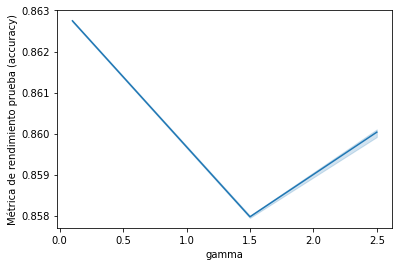

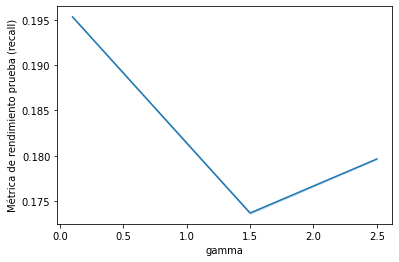

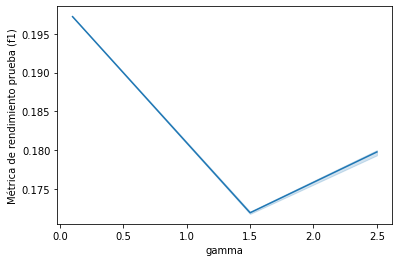

In [9]:
errores=["Métrica de rendimiento prueba (accuracy)","Métrica de rendimiento prueba (recall)","Métrica de rendimiento prueba (f1)"]
for error in errores:
    sns.lineplot(data=resultados_svm,x="gamma",y=error)
    plt.show()

# Gráficas de rendimiento
## Accuracy, recall y f1 respecto a los params_reg

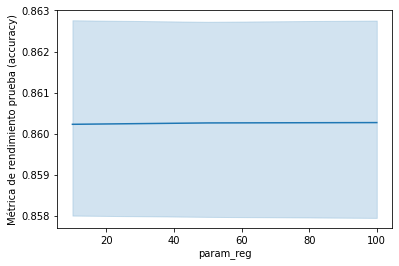

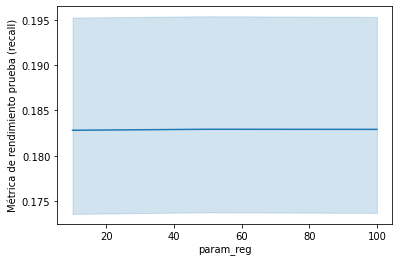

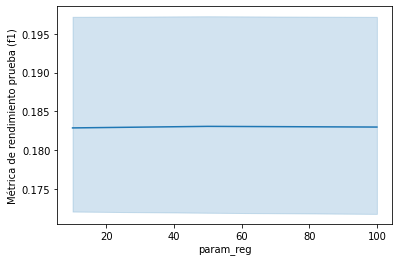

In [11]:
for error in errores:
    sns.lineplot(data=resultados_svm,x="param_reg",y=error)
    plt.show()

## Se carga de nuevo el dataset, ya que se han realizado variaciones

In [3]:
data=pd.read_csv("/kaggle/input/datasetmodified/dataset-modificado.csv")
df=data.copy()
df=df.drop(["Unnamed: 0"],axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,8,17,1,1,5,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,8,22,0,1,5,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,9,19,1,1,3,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,8,21,0,0,4,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,8,14,0,1,5,8.0,0,0,0


## Separamos los datos
Separamos los datos de nuestro dataset, ponemos las características que vamos a utilizar para entrenar en la variable X y la variable a predecir en la varibale Y.

In [4]:
X=df.iloc[:,1:17]
Y=df.iloc[:,0]

## Estandarización de los datos
Usamos StandardScaler para estandarizar las caracteríticas que vamos a usar para entrenar en nuestro modelo.

In [5]:
scaler=StandardScaler()
columns=X.columns
s=scaler.fit_transform(X)

scaled_data=pd.DataFrame(s,columns=columns)
scaled_data.head(5)

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,-1.844750,1.193474,-0.27032,-0.198040,-0.046751,3.281069,-0.401578,-0.951711,0.136184,2.524911,0.538256,0.388307,-1.460354,2.541515,-0.195554,3.118419
1,-1.256338,-0.837890,-0.27032,5.049478,-0.424070,-0.490039,-0.401578,-0.951711,1.538806,-0.396054,0.538256,0.388307,-0.067601,-0.393466,-0.195554,-0.320675
2,-0.274603,1.193474,-0.27032,-0.198040,2.091388,3.281069,-0.401578,1.050739,0.697233,2.524911,0.538256,-1.529392,0.628776,2.541515,-0.195554,-0.320675
3,-0.647473,-0.837890,-0.27032,-0.198040,-0.424070,-0.490039,-0.401578,-0.951711,1.258282,-0.396054,-1.857852,-0.570542,-0.763977,-0.393466,-0.195554,3.118419
4,-0.726138,-0.837890,-0.27032,-0.198040,3.097572,-0.490039,2.490174,-0.951711,-0.705388,-0.396054,0.538256,0.388307,0.628776,-0.393466,-0.195554,-0.320675


## División de los datos
Se realiza una división de los datos en train y test de forma que quedaron 70% y 30% respectivamente

In [6]:
X_train,X_test,y_train,y_test=train_test_split(scaled_data,
                                               Y,
                                               test_size=0.3,
                                               random_state=50)

## Cantidad de datos que hay por clases para predecir

In [7]:
counter=Counter(y_train)
print(counter)

Counter({0: 204624, 1: 19232})


## Función para el entrenamiento de los modelos

In [8]:
def entrenarModelo(model_train, Xtrain,Ytrain,Xtest,Ytest):
    model.fit(X=Xtrain,y=Ytrain)
    Ypred=model.predict(Xtest)

    print(f'Model: {str(model)}')
    print(f'Accuracy Score: {accuracy_score(Ytest,Ypred)}')
    print(f'Precission Score: {precision_score(Ytest,Ypred)}')
    print(f'Recall Score: {recall_score(Ytest,Ypred)}')
    print(f'F1-Score: {f1_score(Ytest,Ypred)}')
    cm = confusion_matrix(Ytest, Ypred, labels=model_train.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_train.classes_)
    disp.plot()
    return model_train

## Función para realizar el Submuestreo de los datos

In [9]:
def balancearClases(balanceador, X_train, y_train):
    Xtrain_new, Ytrain_new=balanceador.fit_resample(X_train,y_train)
    print("Dimensiones")
    print("Xtrain_new: ", Xtrain_new.shape)
    print("Ytrain_new: ", Ytrain_new.shape)
    return Xtrain_new,Ytrain_new

## Entrenamiento del modelo con Undersampling

In [10]:
subsample=RandomUnderSampler()
Xtrain_new, Ytrain_new=balancearClases(subsample, X_train, y_train)

Dimensiones
Xtrain_new:  (38464, 16)
Ytrain_new:  (38464,)


Model: SVC()
Accuracy Score: 0.7309123505560825
Precission Score: 0.21315200103865753
Recall Score: 0.8066576587642795
F1-Score: 0.33720154043645695


['SVM_UnderSampling.joblib']

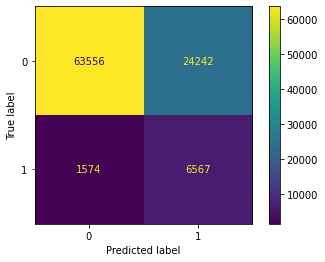

In [10]:
model=SVC()
modelo_entrenado=entrenarModelo(model,Xtrain_new,Ytrain_new,X_test,y_test)
joblib.dump(modelo_entrenado, 'SVM_UnderSampling.joblib') 

## Entrenamiento del modelo con Oversampling

In [11]:
subsample=RandomOverSampler()
Xtrain_new, Ytrain_new=balancearClases(subsample, X_train, y_train)

Dimensiones
Xtrain_new:  (409248, 16)
Ytrain_new:  (409248,)


In [ ]:
model=SVC()
modelo_entrenado=entrenarModelo(model,Xtrain_new,Ytrain_new,X_test,y_test)
joblib.dump(modelo_entrenado, 'SVM_OverSampling.joblib') 

# Entrenamiento del modelo sin usar técnicas de submuestreo

In [ ]:
model=SVC()
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)
joblib.dump(modelo_entrenado, 'SVM.joblib')